### 데이터 읽어오기

In [1]:
import glob
import os, re
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

### 데이터 정제

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(f"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
        
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:5]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>']

### 데이터셋 토큰화

In [3]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                     filters=' ',
                                                     oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post',
                                                          maxlen=20)
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f25ffd89850>


### 평가 데이터셋 분리

In [4]:
# source, target input 생성
src_input = tensor[:,:-1]
tgt_input = tensor[:, 1:]

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, 
                                                          test_size=0.2,
                                                         random_state=2023)

### train_dataset 객체 생성

In [5]:
BUFFER_SIZE=len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

### val_dataset 객체 생성

In [6]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

### 모델 생성

In [7]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

### <span style='color:red'> __embedding_size 조절__ </span>
---
1. 512
2. 300
3. 128

#### 1. embeddingsize=512

In [8]:
embedding_size = 512
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 313s 559ms/step - loss: 2.8446 - val_loss: 2.5464
Epoch 2/10
546/546 [==============================] - 398s 729ms/step - loss: 2.4467 - val_loss: 2.3870
Epoch 3/10
546/546 [==============================] - 438s 802ms/step - loss: 2.3016 - val_loss: 2.2879
Epoch 4/10
546/546 [==============================] - 437s 800ms/step - loss: 2.1925 - val_loss: 2.2189
Epoch 5/10
546/546 [==============================] - 438s 802ms/step - loss: 2.1001 - val_loss: 2.1604
Epoch 6/10
546/546 [==============================] - 437s 801ms/step - loss: 2.0176 - val_loss: 2.1173
Epoch 7/10
546/546 [==============================] - 435s 797ms/step - loss: 1.9411 - val_loss: 2.0808
Epoch 8/10
546/546 [==============================] - 298s 545ms/step - loss: 1.8697 - val_loss: 2.0484
Epoch 9/10
546/546 [==============================] - 298s 546ms/step - loss: 1.8023 - val_loss: 2.0235
Epoch 10/10
546/546 [==============================] - 298s 546m

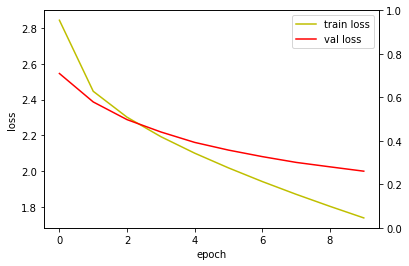

In [13]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

#### 2. embeddingsize=300

In [13]:
embedding_size = 300
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 261s 433ms/step - loss: 2.8837 - val_loss: 2.5709
Epoch 2/10
546/546 [==============================] - 318s 581ms/step - loss: 2.4766 - val_loss: 2.4114
Epoch 3/10
546/546 [==============================] - 317s 580ms/step - loss: 2.3308 - val_loss: 2.3127
Epoch 4/10
546/546 [==============================] - 318s 583ms/step - loss: 2.2244 - val_loss: 2.2432
Epoch 5/10
546/546 [==============================] - 319s 583ms/step - loss: 2.1352 - val_loss: 2.1881
Epoch 6/10
546/546 [==============================] - 319s 584ms/step - loss: 2.0539 - val_loss: 2.1422
Epoch 7/10
546/546 [==============================] - 319s 583ms/step - loss: 1.9793 - val_loss: 2.1046
Epoch 8/10
546/546 [==============================] - 319s 584ms/step - loss: 1.9092 - val_loss: 2.0731
Epoch 9/10
546/546 [==============================] - 319s 583ms/step - loss: 1.8424 - val_loss: 2.0459
Epoch 10/10
546/546 [==============================] - 319s 584m

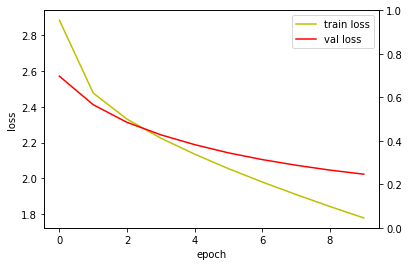

In [15]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

#### 3. embeddingsize=128

In [16]:
embedding_size = 128
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 311s 562ms/step - loss: 2.9343 - val_loss: 2.6261
Epoch 2/10
546/546 [==============================] - 308s 564ms/step - loss: 2.5228 - val_loss: 2.4658
Epoch 3/10
546/546 [==============================] - 307s 562ms/step - loss: 2.3938 - val_loss: 2.3734
Epoch 4/10
546/546 [==============================] - 308s 563ms/step - loss: 2.2930 - val_loss: 2.3036
Epoch 5/10
546/546 [==============================] - 308s 564ms/step - loss: 2.2106 - val_loss: 2.2500
Epoch 6/10
546/546 [==============================] - 306s 561ms/step - loss: 2.1376 - val_loss: 2.2060
Epoch 7/10
546/546 [==============================] - 308s 563ms/step - loss: 2.0699 - val_loss: 2.1691
Epoch 8/10
546/546 [==============================] - 308s 564ms/step - loss: 2.0066 - val_loss: 2.1345
Epoch 9/10
546/546 [==============================] - 308s 564ms/step - loss: 1.9469 - val_loss: 2.1084
Epoch 10/10
546/546 [==============================] - 308s 564m

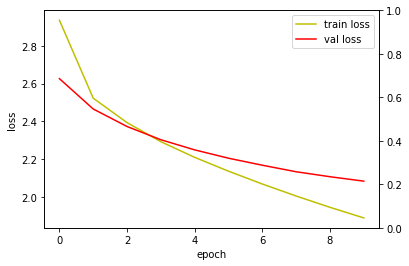

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()